In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_hub as hub

In [ ]:
df = pd.read_csv("wine-reviews.csv", usecols = ['country', 'description', 'points', 'price', 'variety', 'winery'])

In [ ]:
df.head()

,country,description,points,price,variety,winery
0,Italy,"Aromas include tropical fruit, broom, brimston...",87,NaN,White Blend,Nicosia
1,Portugal,"This is ripe and fruity, a wine that is smooth...",87,15.0,Portuguese Red,Quinta dos Avidagos
2,US,"Tart and snappy, the flavors of lime flesh and...",87,14.0,Pinot Gris,Rainstorm
3,US,"Pineapple rind, lemon pith and orange blossom ...",87,13.0,Riesling,St. Julian
4,US,"Much like the regular bottling from 2012, this...",87,65.0,Pinot Noir,Sweet Cheeks


<function matplotlib.pyplot.show(close=None, block=None)>

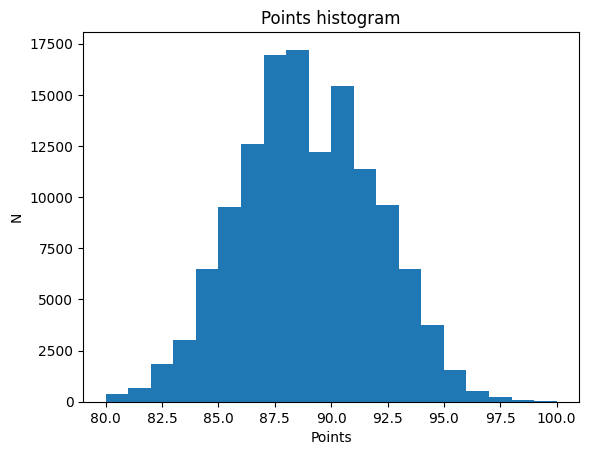

In [ ]:
plt.hist(df.points, bins=20)
plt.title("Points histogram")
plt.ylabel("N")
plt.xlabel("Points")
plt.show

In [ ]:
df["label"] = (df.points >= 90).astype(int)
df = df[["description", "label"]]

In [ ]:
train, val, test = np.split(df.sample(frac=1), [int(0.8*len(df)),int(0.9*len(df))])

In [ ]:
def df_to_dataset(dataframe, shuffle=True, batch_size=1024):
  df = dataframe.copy()
  labels = df.pop('label')
  df = df["description"]
  ds = tf.data.Dataset.from_tensor_slices((df, labels))
  if shuffle:
    ds = ds.shuffle(buffer_size=len(dataframe))
  ds = ds.batch(batch_size)
  ds = ds.prefetch(tf.data.AUTOTUNE)
  return ds

In [ ]:
train_data = df_to_dataset(train)
valid_data = df_to_dataset(val)
test_data = df_to_dataset(test)

# Embedding + Model

In [ ]:
embedding = "https://tfhub.dev/google/nnlm-en-dim50/2"
hub_layer = hub.KerasLayer(embedding, dtype=tf.string, trainable=True)

In [ ]:
hub_layer(list(train_data)[0][0])

<tf.Tensor: shape=(1024, 50), dtype=float32, numpy=
array([[ 0.42184752,  0.00335635,  0.08195051, ...,  0.1060819 ,
         0.06186505, -0.02575756],
       [ 0.4006566 , -0.29766995,  0.06694324, ...,  0.16819513,
        -0.09040349, -0.04628387],
       [ 0.3519181 , -0.282176  , -0.138662  , ..., -0.06375442,
        -0.10109395,  0.25149244],
       ...,
       [ 0.25305155, -0.25429252, -0.13021457, ...,  0.09355961,
        -0.08640638, -0.16905025],
       [ 0.4115391 , -0.04088044, -0.05979303, ..., -0.1440589 ,
         0.04744858, -0.12693861],
       [ 0.45500922, -0.19342607, -0.04547265, ...,  0.01094875,
         0.03107673,  0.09750701]], dtype=float32)>

In [ ]:
model = tf.keras.Sequential()
model.add(hub_layer)
model.add(tf.keras.layers.Dense(16, activation='relu'))
model.add(tf.keras.layers.Dropout(0.4))
model.add(tf.keras.layers.Dense(16, activation='relu'))
model.add(tf.keras.layers.Dropout(0.4))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

In [ ]:
model.evaluate(train_data)

102/102 [==============================] - 18s 173ms/step - loss: 0.5149 - accuracy: 0.7628


[0.5148943066596985, 0.7628106474876404]

In [ ]:
model.evaluate(valid_data)

13/13 [==============================] - 4s 307ms/step - loss: 0.5237 - accuracy: 0.7540


[0.5236663222312927, 0.7540201544761658]

In [ ]:
history = model.fit(train_data, epochs=5, validation_data=valid_data)

Epoch 1/5
102/102 [==============================] - 138s 1s/step - loss: 0.2421 - accuracy: 0.8967 - val_loss: 0.4637 - val_accuracy: 0.8280
Epoch 2/5
102/102 [==============================] - 125s 1s/step - loss: 0.2299 - accuracy: 0.9016 - val_loss: 0.4819 - val_accuracy: 0.8296
Epoch 3/5
102/102 [==============================] - 126s 1s/step - loss: 0.2198 - accuracy: 0.9039 - val_loss: 0.5015 - val_accuracy: 0.8276
Epoch 4/5
102/102 [==============================] - 129s 1s/step - loss: 0.2117 - accuracy: 0.9051 - val_loss: 0.5138 - val_accuracy: 0.8238
Epoch 5/5
102/102 [==============================] - 188s 2s/step - loss: 0.2040 - accuracy: 0.9095 - val_loss: 0.5394 - val_accuracy: 0.8275


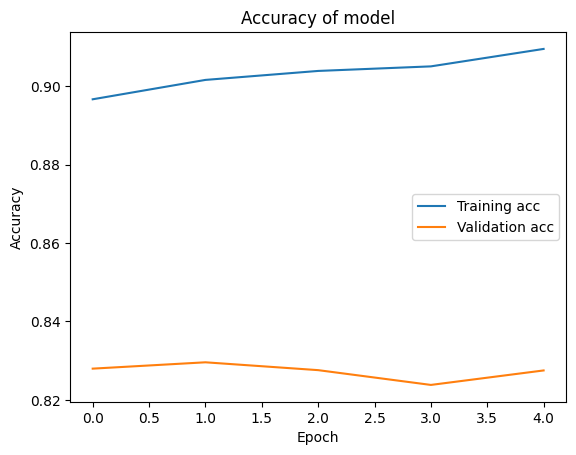

In [ ]:
plt.plot(history.history['accuracy'], label="Training acc")
plt.plot(history.history['val_accuracy'], label="Validation acc")
plt.title("Accuracy of model")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend()
plt.show()

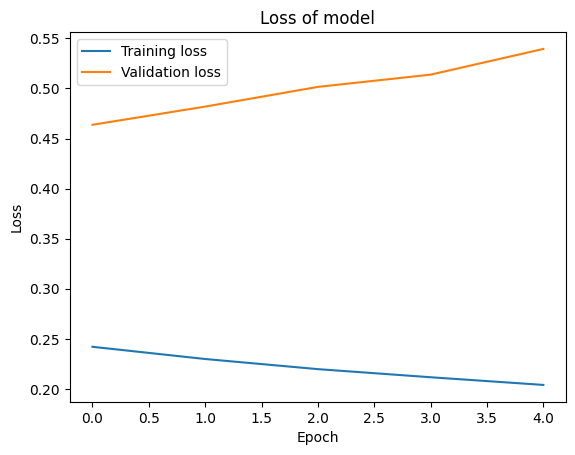

In [ ]:
plt.plot(history.history['loss'], label="Training loss")
plt.plot(history.history['val_loss'], label="Validation loss")
plt.title("Loss of model")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend()
plt.show()

In [ ]:
model.evaluate(test_data)

13/13 [==============================] - 4s 277ms/step - loss: 0.5126 - accuracy: 0.8237


[0.512561023235321, 0.8237420916557312]

# LSTM

In [ ]:
encoder = tf.keras.layers.TextVectorization(max_tokens=2000)
encoder.adapt(train_data.map(lambda text, label: text))

In [ ]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'and', 'the', 'a', 'of', 'with', 'this', 'is', 'wine',
       'flavors', 'in', 'it', 'to', 'its', 'on', 'fruit', 'aromas',
       'palate', 'that'], dtype='<U17')

In [ ]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=32,
        mask_zero=True
    ),
    tf.keras.layers.LSTM(32),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

In [ ]:
model.evaluate(train_data)
model.evaluate(valid_data)

13/13 [==============================] - 2s 187ms/step - loss: 0.6921 - accuracy: 0.5908


[0.6920509934425354, 0.5908286571502686]

In [ ]:
history = model.fit(train_data, epochs=5, validation_data=valid_data)

Epoch 1/5
102/102 [==============================] - 62s 530ms/step - loss: 0.5263 - accuracy: 0.7260 - val_loss: 0.3818 - val_accuracy: 0.8230
Epoch 2/5
102/102 [==============================] - 54s 531ms/step - loss: 0.3622 - accuracy: 0.8388 - val_loss: 0.3609 - val_accuracy: 0.8320
Epoch 3/5
102/102 [==============================] - 54s 525ms/step - loss: 0.3471 - accuracy: 0.8454 - val_loss: 0.3582 - val_accuracy: 0.8355
Epoch 4/5
102/102 [==============================] - 58s 566ms/step - loss: 0.3414 - accuracy: 0.8486 - val_loss: 0.3596 - val_accuracy: 0.8320
Epoch 5/5
102/102 [==============================] - 56s 545ms/step - loss: 0.3357 - accuracy: 0.8512 - val_loss: 0.3587 - val_accuracy: 0.8340


In [ ]:
model.evaluate(test_data)

13/13 [==============================] - 5s 396ms/step - loss: 0.3583 - accuracy: 0.8301


[0.35827094316482544, 0.8300507664680481]